# 라이브러리 선언

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [39]:
# 데이터 호출
train = pd.read_csv('./data/train.csv')

In [70]:
# 데이터 특성 파악
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 84 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

- Demographics- 참가자의 연령 및 성별에 대한 정보.
- Internet Use- 하루에 컴퓨터/인터넷을 사용하는 시간.
- Children's Global Assessment Scale- 정신 건강 임상의가 18세 미만 청소년의 전반적인 기능을 평가하는 데 사용하는 숫자 척도입니다.
- Physical Measures- 혈압, 심박수, 키, 체중, 허리, 엉덩이 측정치를 수집합니다.
- FitnessGram Vitals and Treadmill- NHANES 트레드밀 프로토콜을 사용하여 평가된 심혈관 건강 측정.
- FitnessGram Child- 유산소 운동 능력, 근력, 근지구력, 유연성, 신체 구성을 포함한 5가지 매개변수를 측정하는 건강 관련 체력 평가입니다.
- Bio-electric Impedance Analysis- BMI, 지방, 근육, 수분 함량을 포함한 주요 신체 구성 요소를 측정합니다.
- Physical Activity Questionnaire- 지난 7일 동안 어린이들이 격렬한 활동에 참여한 내용에 대한 정보.
- Sleep Disturbance Scale- 어린이의 수면 장애를 분류하는 척도.
- Actigraphy- 연구용 바이오트래커를 통한 생태학적 신체 활동의 객관적 측정.
- Parent-Child Internet Addiction Test- 강박성, 현실도피주의, 의존성을 포함하여 인터넷 강박적 사용과 관련된 특성과 행동을 측정하는 20문항 척도입니다.

In [79]:
train['PCIAT-PCIAT_19'].unique()

array([ 2.,  0.,  1.,  4., nan,  3.,  5.])

In [76]:
train['sii'].nunique() # 비지도로 대체하기, 지도 학습으로 대체하기 두가지 방법론 검토

4

# CGAS 기준 컬럼 분석

In [42]:
cgas_columns = [col for col in train.columns if col.startswith('CGAS')]
cgas_nan_counts = train[cgas_columns].isna().sum()
print("'CGAS'로 시작하는 컬럼들의 NaN 값 개수:")
print(cgas_nan_counts)

'CGAS'로 시작하는 컬럼들의 NaN 값 개수:
CGAS-Season        1405
CGAS-CGAS_Score    1539
dtype: int64


CGAS-CGAS_Score 결측값 (CGAS-Season이 존재하는 경우) : 134개

나이 : 5 ~ 22세
성별 : 남성 - 1632명 , 여성 - 923명

score 분포 (이상치 제거 전)


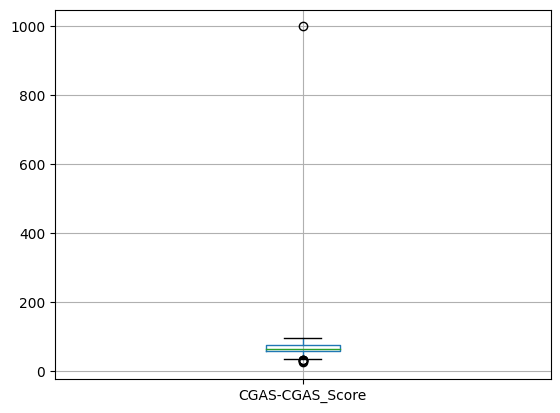

score 분포 (이상치 제거 후)


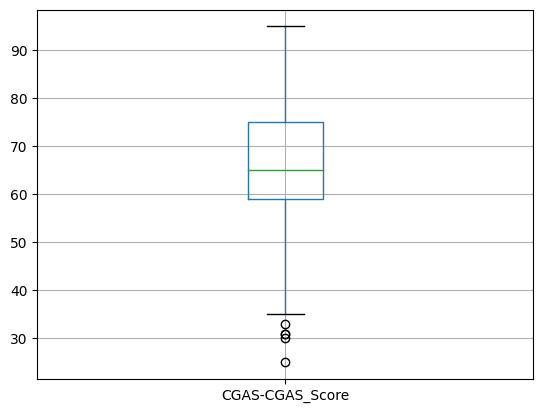

CGAS_Score와 인터넷 이용시간(PreInt_EduHx-computerinternet_hoursday)의 산점도


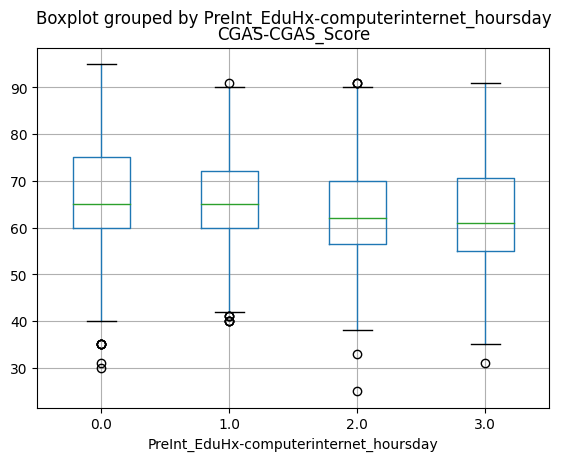

CGAS_Score와 Sii의 산점도


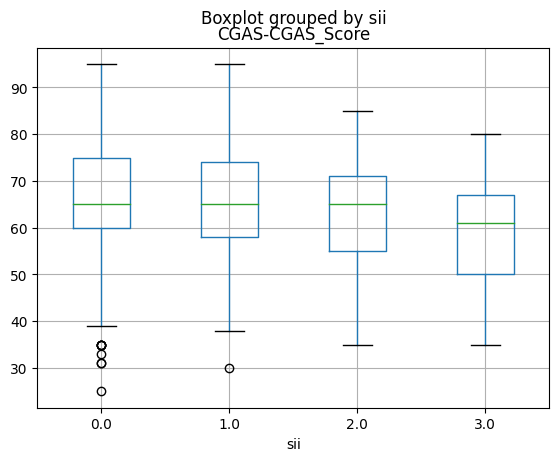

In [43]:
cgas_df = train[~train['CGAS-Season'].isna() | ~train['CGAS-CGAS_Score'].isna()]

score_na = cgas_df['CGAS-CGAS_Score'].isna().sum()
print(f'CGAS-CGAS_Score 결측값 (CGAS-Season이 존재하는 경우) : {score_na}개', end = '\n\n')

min_age = cgas_df['Basic_Demos-Age'].min()
max_age = cgas_df['Basic_Demos-Age'].max()
print(f'나이 : {min_age} ~ {max_age}세')

male = len(cgas_df[cgas_df['Basic_Demos-Sex'] == 0])
print(f'성별 : 남성 - {male}명 , 여성 - {len(cgas_df)-male}명', end = '\n\n')

print("score 분포 (이상치 제거 전)")
cgas_df.boxplot(column = ['CGAS-CGAS_Score'])
plt.show()
print("score 분포 (이상치 제거 후)")
cgas_df[cgas_df['CGAS-CGAS_Score'] != 999].boxplot(column = ['CGAS-CGAS_Score'])
plt.show()

print('CGAS_Score와 인터넷 이용시간(PreInt_EduHx-computerinternet_hoursday)의 산점도')
cgas_df[(cgas_df['CGAS-CGAS_Score'] != 999) & (~cgas_df['PreInt_EduHx-computerinternet_hoursday'].isna())].boxplot(by='PreInt_EduHx-computerinternet_hoursday',column = 'CGAS-CGAS_Score')
plt.show()

print('CGAS_Score와 Sii의 산점도')
cgas_df[~cgas_df.sii.isna()].boxplot(by='sii',column='CGAS-CGAS_Score')
plt.show()

# Physical로 시작하는 컬럼 데이터 분석

Case : when only Weight is NaN, All Heights are  0
[0.]
Case : when only Height is NaN, All Weights have data
[58.  57.5 61.5 56.  72. ]



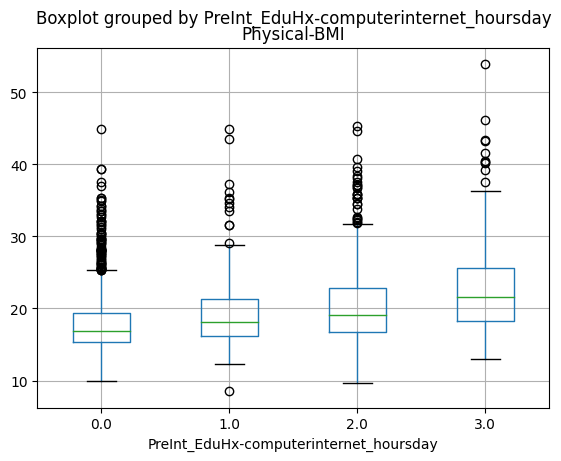

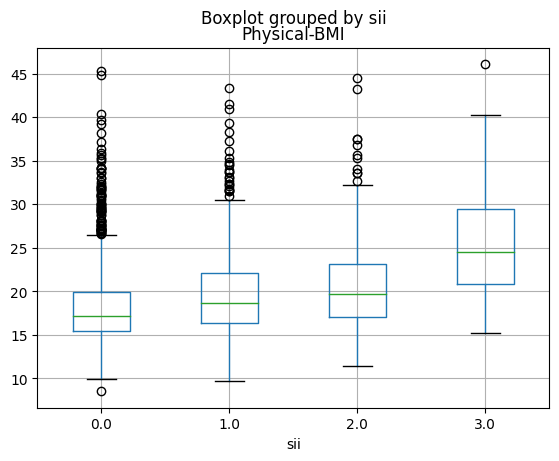

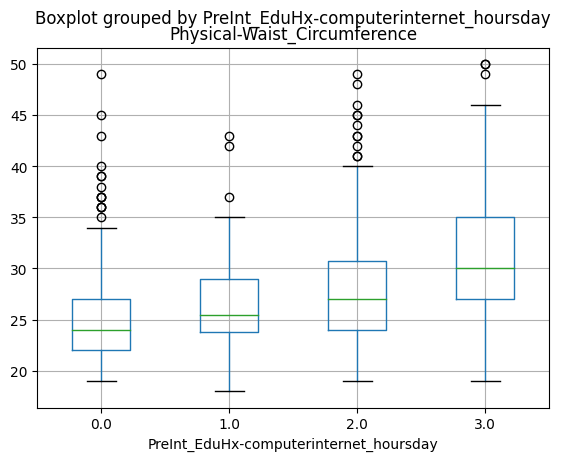

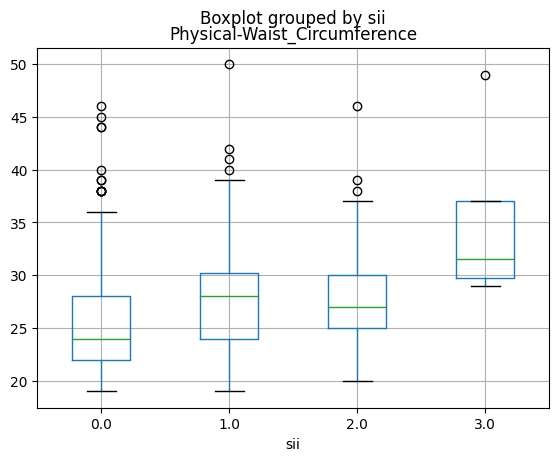

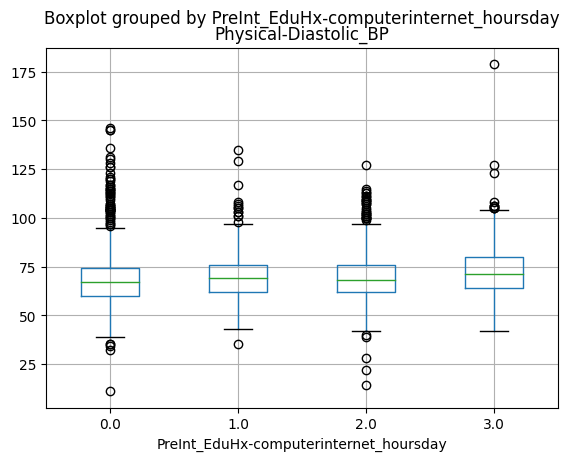

인터넷 이용 시간 : 고혈압 (Diastolic_BP >= 90) 비율
PreInt_EduHx-computerinternet_hoursday
0.0    0.069572
1.0    0.072674
2.0    0.053927
3.0    0.124183
Name: Physical-Diastolic_BP, dtype: float64


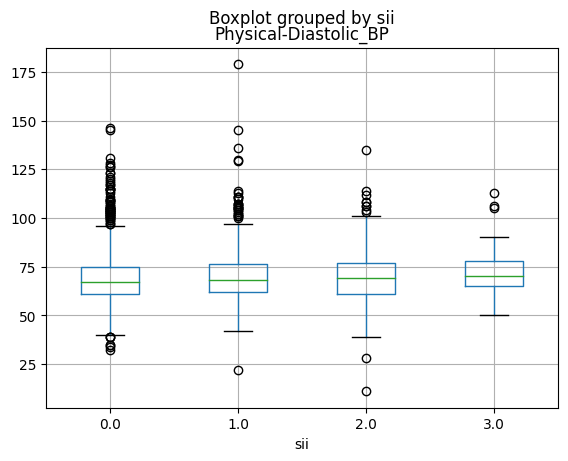

SII 점수 : 고혈압 (Diastolic_BP >= 90) 비율
sii
0.0    0.066852
1.0    0.084337
2.0    0.081159
3.0    0.121212
Name: Physical-Diastolic_BP, dtype: float64


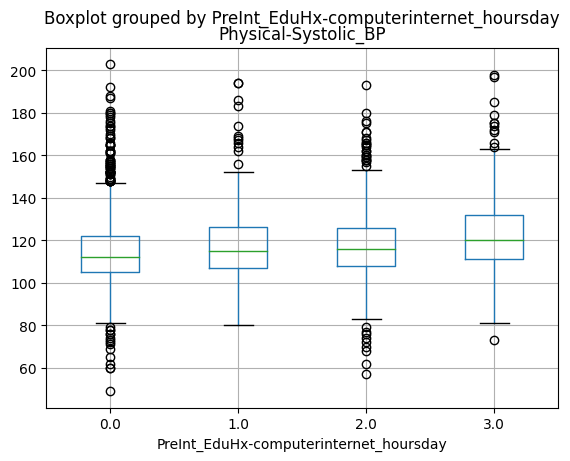

인터넷 이용 시간 : 고혈압 (Systolic_BP >= 130) 비율
PreInt_EduHx-computerinternet_hoursday
0.0    0.144495
1.0    0.206395
2.0    0.188746
3.0    0.294118
Name: Physical-Systolic_BP, dtype: float64


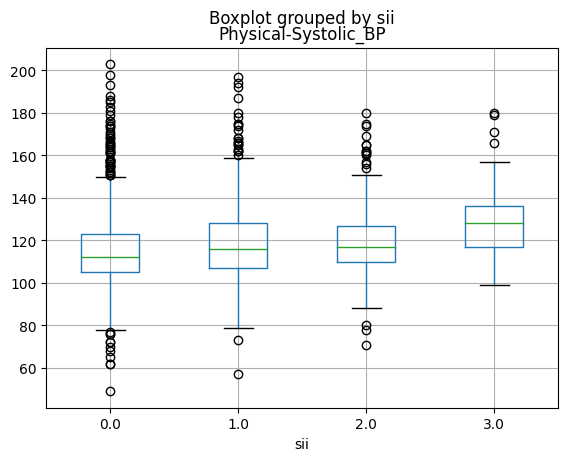

SII 점수 : 고혈압 (Systolic_BP >= 130) 비율
sii
0.0    0.151114
1.0    0.228916
2.0    0.240580
3.0    0.393939
Name: Physical-Systolic_BP, dtype: float64


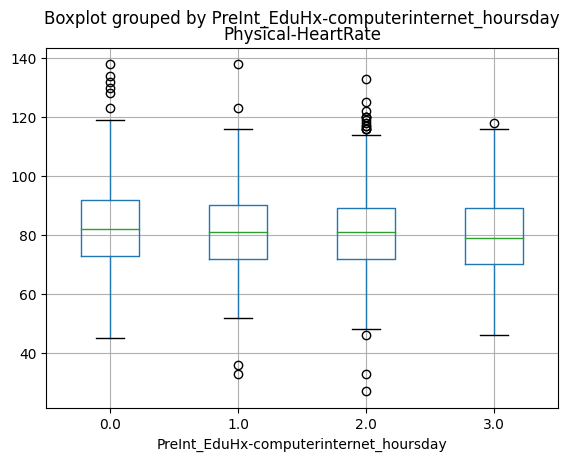

outrange of HeartRate by computerinternet_hoursday
PreInt_EduHx-computerinternet_hoursday
0.0    0.245614
1.0    0.208092
2.0    0.181395
3.0    0.150820
Name: HeartRate_Normal, dtype: float64


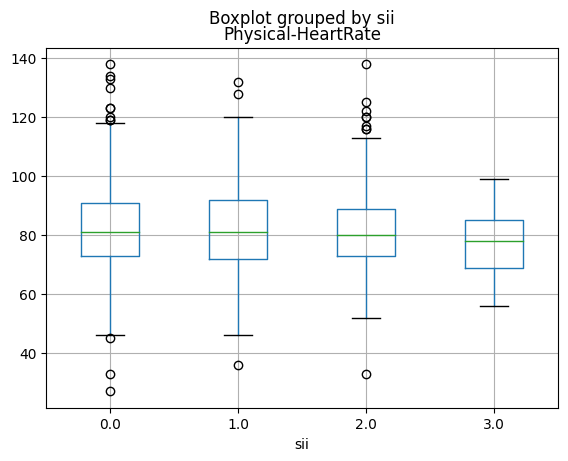

outrange of HeartRate by sii
sii
0.0    0.238692
1.0    0.226528
2.0    0.133333
3.0    0.030303
Name: HeartRate_Normal, dtype: float64


In [44]:
print('Case : when only Weight is NaN, All Heights are  0')
print(train[(train['Physical-Height'].isna()) & (~train['Physical-Weight'].isna())]['Physical-Weight'].unique()) #54개
print('Case : when only Height is NaN, All Weights have data')
print(train[(~train['Physical-Height'].isna()) & (train['Physical-Weight'].isna())]['Physical-Height'].unique(), end = '\n\n') #5개 

bmi = train[~(train['Physical-BMI'].isna()) & (train['Physical-BMI'] != 0)]

bmi.boxplot(by='PreInt_EduHx-computerinternet_hoursday',column ='Physical-BMI')
plt.show()

bmi.boxplot(by='sii',column='Physical-BMI')
plt.show()

Waist_Circumference = train[~train['Physical-Waist_Circumference'].isna()]
bmi.boxplot(column='Physical-Waist_Circumference',by ='PreInt_EduHx-computerinternet_hoursday')
plt.show()

bmi.boxplot(column='Physical-Waist_Circumference',by ='sii')
plt.show()

train[~train['Physical-Diastolic_BP'].isna()].boxplot(column='Physical-Diastolic_BP',by ='PreInt_EduHx-computerinternet_hoursday')
plt.show()
print('인터넷 이용 시간 : 고혈압 (Diastolic_BP >= 90) 비율')
a = train[train['Physical-Diastolic_BP'] >= 90].groupby('PreInt_EduHx-computerinternet_hoursday')['Physical-Diastolic_BP'].count()
b = train[~train['Physical-Diastolic_BP'].isna()].groupby('PreInt_EduHx-computerinternet_hoursday')['Physical-Diastolic_BP'].count()
print(a/b)

train[~train['Physical-Diastolic_BP'].isna()].boxplot(column='Physical-Diastolic_BP',by ='sii')
plt.show()
print('SII 점수 : 고혈압 (Diastolic_BP >= 90) 비율')
a = train[train['Physical-Diastolic_BP'] >= 90].groupby('sii')['Physical-Diastolic_BP'].count()
b = train[~train['Physical-Diastolic_BP'].isna()].groupby('sii')['Physical-Diastolic_BP'].count()
print(a/b)

train[~train['Physical-Systolic_BP'].isna()].boxplot(column='Physical-Systolic_BP',by ='PreInt_EduHx-computerinternet_hoursday')
plt.show()
print('인터넷 이용 시간 : 고혈압 (Systolic_BP >= 130) 비율')
a = train[train['Physical-Systolic_BP'] >= 130].groupby('PreInt_EduHx-computerinternet_hoursday')['Physical-Systolic_BP'].count()
b = train[~train['Physical-Systolic_BP'].isna()].groupby('PreInt_EduHx-computerinternet_hoursday')['Physical-Systolic_BP'].count()
print(a/b)

train[~train['Physical-Systolic_BP'].isna()].boxplot(column='Physical-Systolic_BP',by ='sii')
plt.show()
print('SII 점수 : 고혈압 (Systolic_BP >= 130) 비율')
a = train[train['Physical-Systolic_BP'] >= 130].groupby('sii')['Physical-Systolic_BP'].count()
b = train[~train['Physical-Systolic_BP'].isna()].groupby('sii')['Physical-Systolic_BP'].count()
print(a/b)

#  4~5, 6~8, 9~11, 12~15, 16~19, 20~39, 59
def is_heart_rate_normal(age, heart_rate):
    if 1 <= age <= 2:
        normal_range = (98, 140)
    elif 3 <= age <= 5:
        normal_range = (80, 120)
    elif 6 <= age <= 11:
        normal_range = (75, 118)
    elif age >= 12:
        normal_range = (60, 100)
    else:
        return np.nan
    # 심박수가 정상 범위 내에 있는지 확인
    if pd.isna(heart_rate):
        return np.nan
    elif normal_range[0] <= heart_rate <= normal_range[1]:
        return 1 #정상
    else:
        return 0 #비정상

# 새로운 컬럼 추가
train['HeartRate_Normal'] = train.apply(lambda row: is_heart_rate_normal(row['Basic_Demos-Age'], 
                                                                        row['Physical-HeartRate']), axis=1)


train[~train['Physical-HeartRate'].isna()].boxplot(column='Physical-HeartRate',by ='PreInt_EduHx-computerinternet_hoursday')
plt.show()
print('outrange of HeartRate by computerinternet_hoursday')
print(1 - train[~train['HeartRate_Normal'].isna()].groupby('PreInt_EduHx-computerinternet_hoursday')['HeartRate_Normal'].mean())

train[~train['Physical-HeartRate'].isna()].boxplot(column='Physical-HeartRate',by ='sii')
plt.show()
print('outrange of HeartRate by sii')
print(1 - train[~train['HeartRate_Normal'].isna()].groupby('sii')['HeartRate_Normal'].mean())

In [62]:
physical_columns = [col for col in train.columns if col.startswith('Physical')]

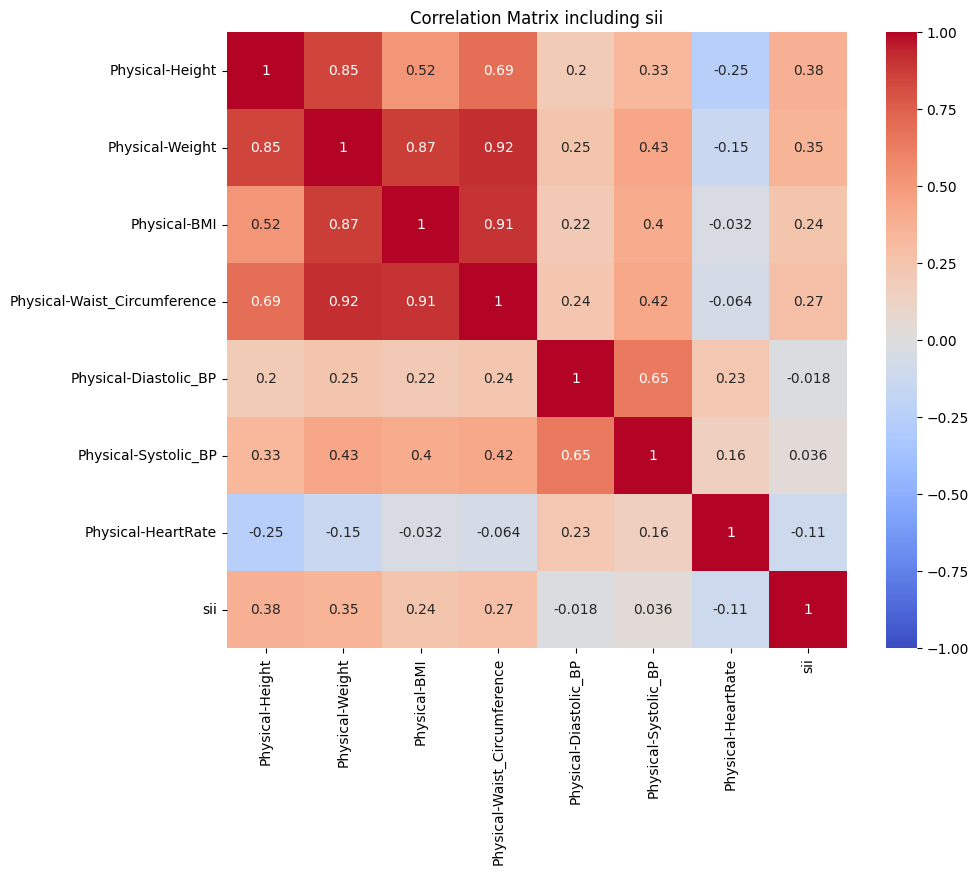

In [66]:
# 'sii' 컬럼 포함하여 상관관계 분석을 위한 데이터셋 준비
features_with_sii = train[['Physical-Height', 'Physical-Weight', 'Physical-BMI', 
                           'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 
                           'Physical-Systolic_BP', 'Physical-HeartRate', 'sii']].dropna()

# 상관계수 계산
correlation_matrix_with_sii = features_with_sii.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_with_sii, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix including sii')
plt.show()


In [49]:
import pandas as pd
import numpy as np


# 다중공선성 확인을 위한 변수 선택
# 'sii' 컬럼 제외, NaN 값은 일단 제거하고 분석 진행
features = train[['Physical-Height', 'Physical-Weight', 'Physical-BMI', 
                  'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 
                  'Physical-Systolic_BP', 'Physical-HeartRate']].dropna()

# VIF 계산을 위한 DataFrame 생성
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

print("Variance Inflation Factor (VIF) Table")
print(vif_data)


Variance Inflation Factor (VIF) Table
                        feature         VIF
0               Physical-Height  100.993657
1               Physical-Weight   34.328474
2                  Physical-BMI  100.395267
3  Physical-Waist_Circumference  212.160791
4         Physical-Diastolic_BP   61.043450
5          Physical-Systolic_BP  119.416258
6            Physical-HeartRate   40.913000


In [50]:
# BMI 제거 후 VIF 재계산
features_reduced = features.drop(columns=['Physical-BMI'])
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = features_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(features_reduced.values, i) for i in range(len(features_reduced.columns))]

print("Variance Inflation Factor (VIF) Table after removing BMI")
print(vif_data_reduced)


Variance Inflation Factor (VIF) Table after removing BMI
                        feature         VIF
0               Physical-Height   75.790058
1               Physical-Weight   27.866476
2  Physical-Waist_Circumference  121.550613
3         Physical-Diastolic_BP   60.762883
4          Physical-Systolic_BP  118.001363
5            Physical-HeartRate   39.182242


# Fitness 컬럼

Max_Stage 분포


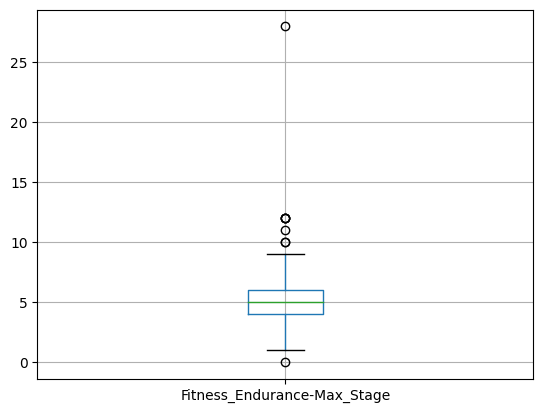

Max_stage max값 (28) 제거 후 분포


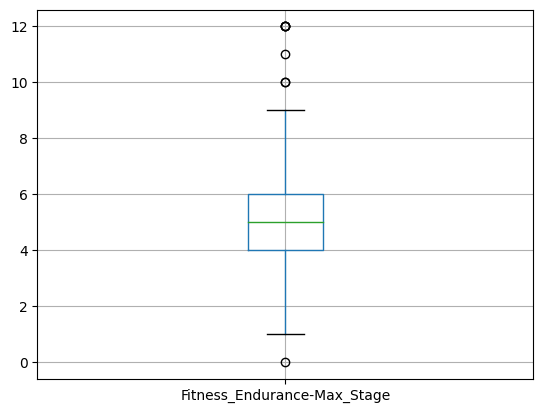

인터넷 이용시간 별 Max_stage 분포


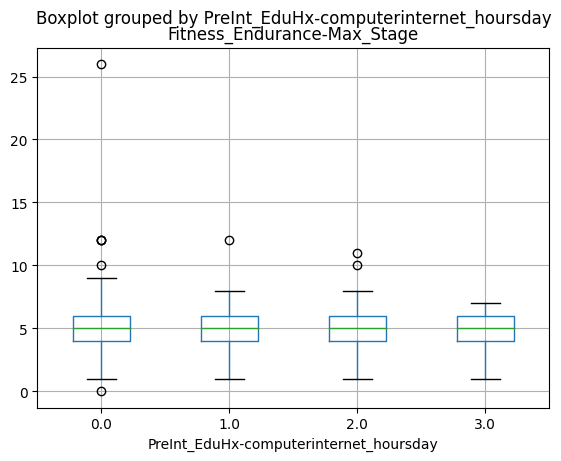

sii 별 Max_stage 분포


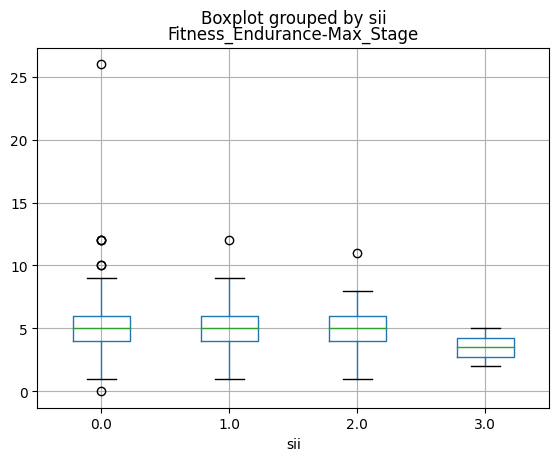

Fitness_Endurance Time(sec) 분포


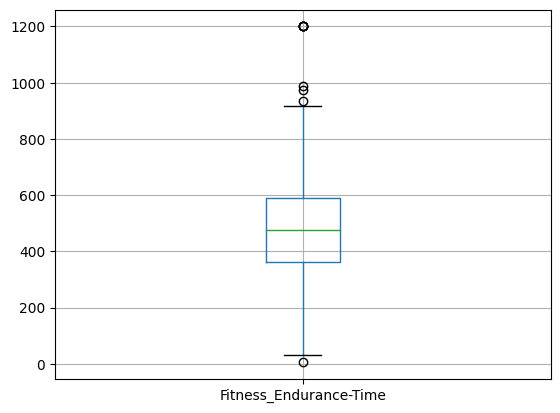

인터넷 이용시간 별 Fitness_Endurance Time(sec) 분포


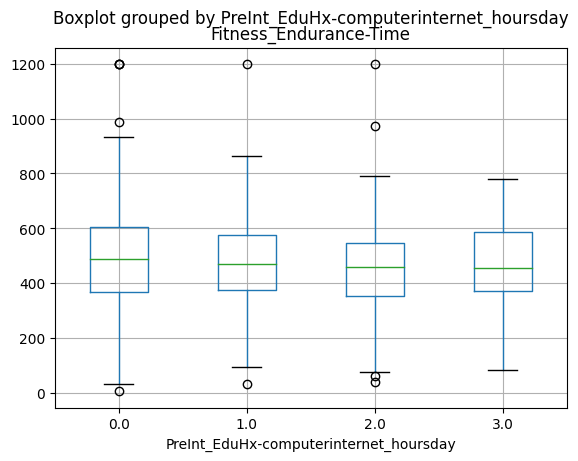

sii 별 Fitness_Endurance Time(sec) 분포


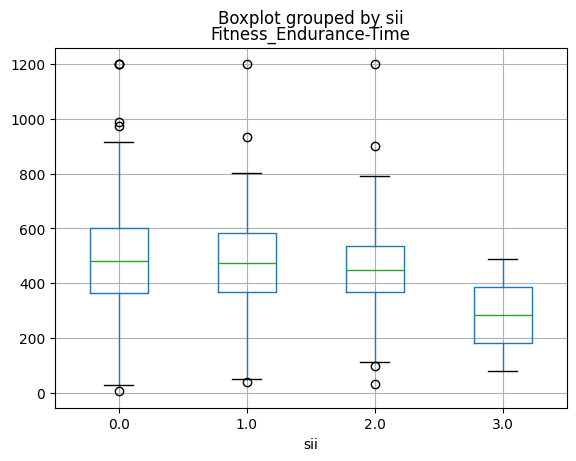

In [45]:
fitness = train[['Fitness_Endurance-Season','Fitness_Endurance-Max_Stage','Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec']].dropna()

print('Max_Stage 분포')
fitness[['Fitness_Endurance-Max_Stage']].boxplot()
plt.show()
print('Max_stage max값 (28) 제거 후 분포')
fitness[fitness['Fitness_Endurance-Max_Stage'] != 28][['Fitness_Endurance-Max_Stage']].boxplot()
plt.show()
print('인터넷 이용시간 별 Max_stage 분포')
train[(train['Fitness_Endurance-Max_Stage'] != 28) & (~train['Fitness_Endurance-Max_Stage'].isna())].boxplot(column = 'Fitness_Endurance-Max_Stage', by ='PreInt_EduHx-computerinternet_hoursday' )
plt.show()
print('sii 별 Max_stage 분포')
train[(train['Fitness_Endurance-Max_Stage'] != 28) & (~train['Fitness_Endurance-Max_Stage'].isna())].boxplot(column = 'Fitness_Endurance-Max_Stage', by ='sii' )
plt.show()


fitness['Fitness_Endurance-Time'] = fitness['Fitness_Endurance-Time_Mins']*60 + fitness['Fitness_Endurance-Time_Sec']
print('Fitness_Endurance Time(sec) 분포')
fitness[['Fitness_Endurance-Time']].boxplot()
plt.show()

train['Fitness_Endurance-Time'] = train['Fitness_Endurance-Time_Mins']*60 + train['Fitness_Endurance-Time_Sec']
print('인터넷 이용시간 별 Fitness_Endurance Time(sec) 분포')
train[~train['Fitness_Endurance-Time'].isna()].boxplot(column = 'Fitness_Endurance-Time', by ='PreInt_EduHx-computerinternet_hoursday' )
plt.show()
print('sii 별 Fitness_Endurance Time(sec) 분포')
train[~train['Fitness_Endurance-Time'].isna()].boxplot(column = 'Fitness_Endurance-Time', by ='sii' )
plt.show()

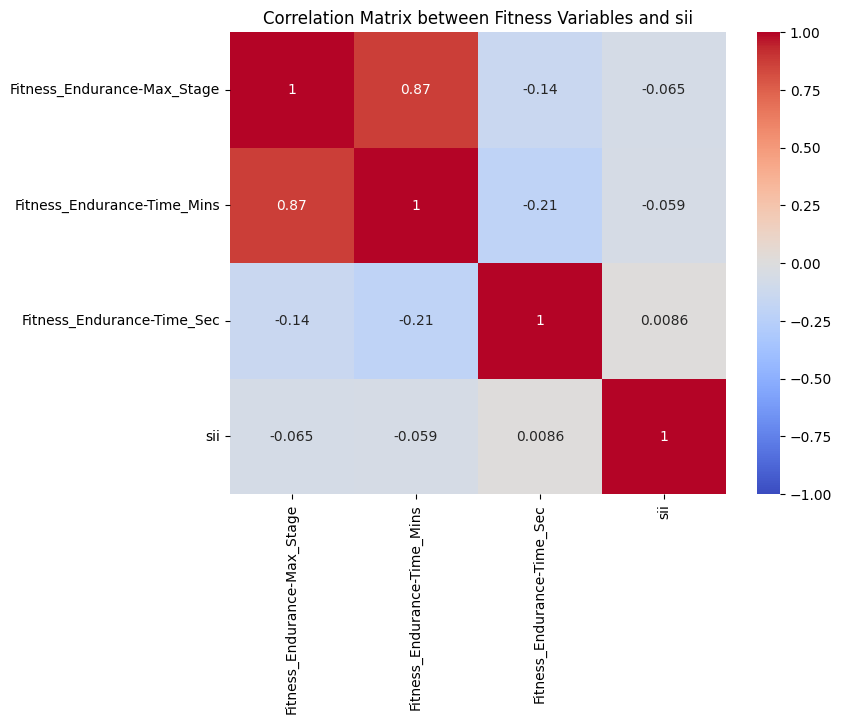

In [69]:
# fitness 데이터프레임에 sii 컬럼 추가
fitness_with_sii = train[['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 
                          'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'sii']].dropna()

# 상관계수 계산
correlation_matrix_fitness_sii = fitness_with_sii.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_fitness_sii, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between Fitness Variables and sii')
plt.show()
